In [1]:
from collect_data import *
from collect_metrics import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
subjects_list = ['01', '02', '04', '05', '06', '07', '08', '09']

stimuli_path = meg_path + '/stimuli/audio'
wav_files_duration = {}

for filename in os.listdir(stimuli_path):
    if filename.endswith('.wav'): 
        file_path = os.path.join(stimuli_path, filename)
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        wav_files_duration[filename.rstrip('.wav')] = duration
print('WAVE FILES DURATION: ',wav_files_duration)
print('WAVE FILES WITH\ NUMBERS: ',task)
wav_list_without_numb = list(task.keys())


megsp_path = os.path.join(meg_path, 'collect_data/megsp')
megsp_list = os.listdir(megsp_path)


WAVE FILES DURATION:  {'lw1': 318.1481632653061, 'lw1_3': 53.072426303854876, 'lw1_2': 93.7512925170068, 'lw1_1': 75.44276643990929, 'lw1_0': 95.88167800453515, 'easy_money_7': 129.30312925170068, 'easy_money_6': 123.42730158730159, 'easy_money_4': 163.68920634920636, 'easy_money_5': 142.36866213151927, 'easy_money_3': 141.97519274376418, 'easy_money_0': 143.12875283446712, 'easy_money_2': 180.43360544217688, 'easy_money_1': 104.10834467120182, 'cable_spool_fort_4': 123.26390022675737, 'cable_spool_fort_5': 54.69605442176871, 'cable_spool_fort_3': 105.82820861678005, 'cable_spool_fort_2': 137.65614512471655, 'cable_spool_fort_1': 134.8726984126984, 'cable_spool_fort_0': 100.59777777777778, 'the_black_willow_9': 188.23668934240362, 'the_black_willow_8': 142.4142403628118, 'the_black_willow_7': 172.399410430839, 'the_black_willow_6': 128.21628117913832, 'the_black_willow_5': 81.94331065759637, 'the_black_willow_4': 110.45659863945578, 'the_black_willow_2': 125.23859410430839, 'the_black_

## Build 8 (or 1) subjects prediction

In [176]:
extr_path = meg_path + "/collect_data"
subjects_metrics = {}

# outer_progress = tqdm(os.listdir(extr_path)[3:-2], desc='Subject Loop')
for repo in tqdm(os.listdir(extr_path)[3:-3]):
    subject = repo[-2:]
    print(subject)

    megsp_list_session_0 = [f for f in megsp_list if f.startswith(subject) and f.split('_')[1] == '0']
    megsp_list_session_1 = [f for f in megsp_list if f.startswith(subject) and f.split('_')[1] == '1']
    meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
    meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
    meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)
    meg_tensor_test = meg_tensor_test[19:-1]
    
    subj_path = extr_path + '/' + repo + '/'
    pred_meg_y = torch.load(os.path.join(subj_path, 'meg_prediction_ridge_text_clip_'+subject+'.pt')) 
    pred_meg_y = pred_meg_y.permute(1, 0, 2)
    pred_meg_y = pred_meg_y.reshape(pred_meg_y.shape[0], pred_meg_y.shape[1], 16, 26)
    subjects_metrics['subject_'+subject] = bands_metrics(meg_tensor_test, pred_meg_y, freq_bands_tot)



    

  0%|          | 0/8 [00:00<?, ?it/s]

01


 12%|█▎        | 1/8 [00:59<06:59, 59.91s/it]

02


 25%|██▌       | 2/8 [02:01<06:05, 60.85s/it]

04


 38%|███▊      | 3/8 [03:00<05:01, 60.21s/it]

05


 50%|█████     | 4/8 [03:59<03:58, 59.74s/it]

06


 62%|██████▎   | 5/8 [05:01<03:01, 60.46s/it]

07


 75%|███████▌  | 6/8 [05:58<01:58, 59.23s/it]

08


 88%|████████▊ | 7/8 [06:55<00:58, 58.53s/it]

09


100%|██████████| 8/8 [07:54<00:00, 59.37s/it]


Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:49: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


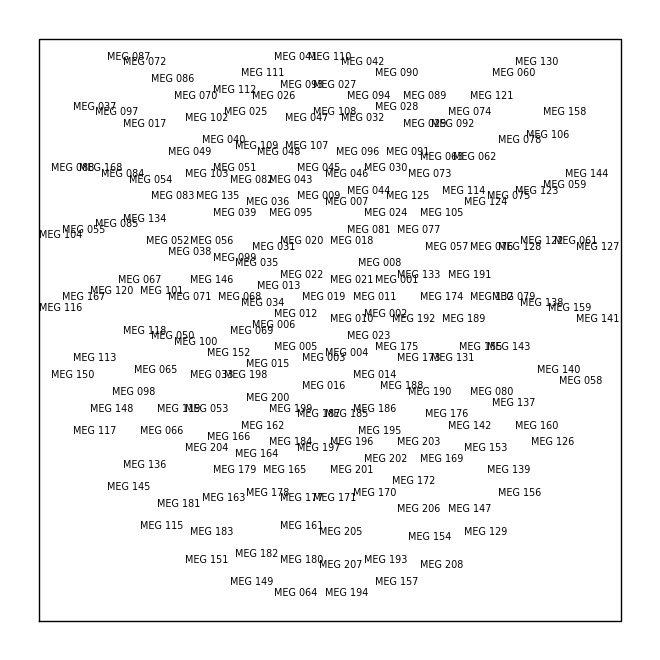

Figure(640x640)


In [4]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')
layout_from_raw = mne.channels.find_layout(raw.info, ch_type='mag')
print(layout_from_raw.plot())

In [ ]:
complete_corr = [entry['pearson_corr'] for entry in subjects_metrics['subject_02']['complete']]
delta_corr = [entry['pearson_corr'] for entry in subjects_metrics['subject_02']['delta']]
theta_corr = [entry['pearson_corr'] for entry in subjects_metrics['subject_02']['theta']]
alpha_corr = [entry['pearson_corr'] for entry in subjects_metrics['subject_02']['alpha']]
beta_corr = [entry['pearson_corr'] for entry in subjects_metrics['subject_02']['beta']]


## Among all subjects

In [177]:
data_frame = []
for subject, metrics in subjects_metrics.items():
    for band, channels in metrics.items():
        for channel_data in channels:
            row = {'Subject': subject, 'Band': band, 'Channel': channel_data['channel']}
            row.update(channel_data)
            del row['channel']  
            data_frame.append(row)

df = pd.DataFrame(data_frame)

In [ ]:
df.to_csv('/data01/data/MEG/collect_data/results/prova.csv', index=False)  
prova_df = pd.read_csv('/data01/data/MEG/collect_data/results/prova.csv')


In [178]:
df

,Subject,Band,Channel,pearson_corr,modified_r2,mse,mae,mae_norm,nmi
0,subject_01,complete,0,-0.006124,-0.000037,55.999272,5.682112,0.277601,0.0
1,subject_01,complete,1,-0.005280,-0.000028,64.808991,5.866192,0.287257,0.0
2,subject_01,complete,2,0.016267,0.000265,52.048294,5.529510,0.307358,0.0
3,subject_01,complete,3,-0.002508,-0.000006,65.267709,5.915640,0.298864,0.0
4,subject_01,complete,4,0.001681,0.000003,57.357871,5.707076,0.301487,0.0
...,...,...,...,...,...,...,...,...,...
8315,subject_09,beta,203,-0.002358,-0.000006,63.005802,5.962819,0.269486,0.0
8316,subject_09,beta,204,-0.003242,-0.000011,58.081302,5.866743,0.285225,0.0
8317,subject_09,beta,205,-0.021815,-0.000476,72.553924,6.308286,0.290793,0.0
8318,subject_09,beta,206,-0.019057,-0.000363,66.702564,6.171378,0.275773,0.0


In [179]:
# media rispetto a tutti i soggetti

def get_mean_from_subjects_metrics(column, band):

    values_to_mean = []
    for subject in subjects_list: 
        get_values = torch.Tensor([entry[column] for entry in subjects_metrics['subject_'+subject][band]])
        values_to_mean.append(get_values)
    mean_channels = torch.mean(torch.stack(values_to_mean), dim=0)
    return mean_channels
        


In [180]:
mean_r2_complete_subj = get_mean_from_subjects_metrics("modified_r2", "complete")
mean_r2_delta_subj = get_mean_from_subjects_metrics("modified_r2", "delta")
mean_r2_theta_subj = get_mean_from_subjects_metrics("modified_r2", "theta")
mean_r2_alpha_subj = get_mean_from_subjects_metrics("modified_r2", "alpha")
mean_r2_beta_subj = get_mean_from_subjects_metrics("modified_r2", "beta")

mean_pc_complete_subj = get_mean_from_subjects_metrics("pearson_corr", "complete")
mean_pc_delta_subj = get_mean_from_subjects_metrics("pearson_corr", "delta")
mean_pc_theta_subj = get_mean_from_subjects_metrics("pearson_corr", "theta")
mean_pc_alpha_subj = get_mean_from_subjects_metrics("pearson_corr", "alpha")
mean_pc_beta_subj = get_mean_from_subjects_metrics("pearson_corr", "beta")

In [181]:
print('-------------- PEARSON --------------')
print('COMPLETE_MEAN: ', "{:.7f}".format(mean_pc_complete_subj.mean()))
print('DELTA_MEAN: ', "{:.7f}".format(mean_pc_delta_subj.mean()))
print('THETA_MEAN: ', "{:.7f}".format(mean_pc_theta_subj.mean()))
print('ALPHA_MEAN: ', "{:.7f}".format(mean_pc_alpha_subj.mean()))
print('BETA_MEAN: ', "{:.7f}".format(mean_pc_beta_subj.mean()))
print('--------------------------------------')
print('COMPLETE_MEAN: ', "{:.7f}".format(mean_pc_complete_subj.std()))
print('DELTA_MEAN: ', "{:.7f}".format(mean_pc_delta_subj.std()))
print('THETA_MEAN: ', "{:.7f}".format(mean_pc_theta_subj.std()))
print('ALPHA_MEAN: ', "{:.7f}".format(mean_pc_alpha_subj.std()))
print('BETA_MEAN: ', "{:.7f}".format(mean_pc_beta_subj.std()))


-------------- PEARSON --------------
COMPLETE_MEAN:  0.0056044
DELTA_MEAN:  0.0013140
THETA_MEAN:  0.0015204
ALPHA_MEAN:  0.0091219
BETA_MEAN:  0.0062928
--------------------------------------
COMPLETE_MEAN:  0.0047989
DELTA_MEAN:  0.0017720
THETA_MEAN:  0.0046200
ALPHA_MEAN:  0.0051130
BETA_MEAN:  0.0062890


In [182]:
print('---------------- R2 ----------------')
print('COMPLETE_MEAN: ', "{:.7f}".format(mean_r2_complete_subj.mean()))
print('DELTA_MEAN: ', "{:.7f}".format(mean_r2_delta_subj.mean()))
print('THETA_MEAN: ', "{:.7f}".format(mean_r2_theta_subj.mean()))
print('ALPHA_MEAN: ', "{:.7f}".format(mean_r2_alpha_subj.mean()))
print('BETA_MEAN: ', "{:.7f}".format(mean_r2_beta_subj.mean()))
print('--------------------------------------')
print('COMPLETE_MEAN: ', "{:.7f}".format(mean_r2_complete_subj.std()))
print('DELTA_MEAN: ', "{:.7f}".format(mean_r2_delta_subj.std()))
print('THETA_MEAN: ', "{:.7f}".format(mean_r2_theta_subj.std()))
print('ALPHA_MEAN: ', "{:.7f}".format(mean_r2_alpha_subj.std()))
print('BETA_MEAN: ', "{:.7f}".format(mean_r2_beta_subj.std()))


---------------- R2 ----------------
COMPLETE_MEAN:  0.0001874
DELTA_MEAN:  0.0000100
THETA_MEAN:  0.0000640
ALPHA_MEAN:  0.0003003
BETA_MEAN:  0.0002752
--------------------------------------
COMPLETE_MEAN:  0.0003188
DELTA_MEAN:  0.0000150
THETA_MEAN:  0.0001559
ALPHA_MEAN:  0.0003123
BETA_MEAN:  0.0005506


meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


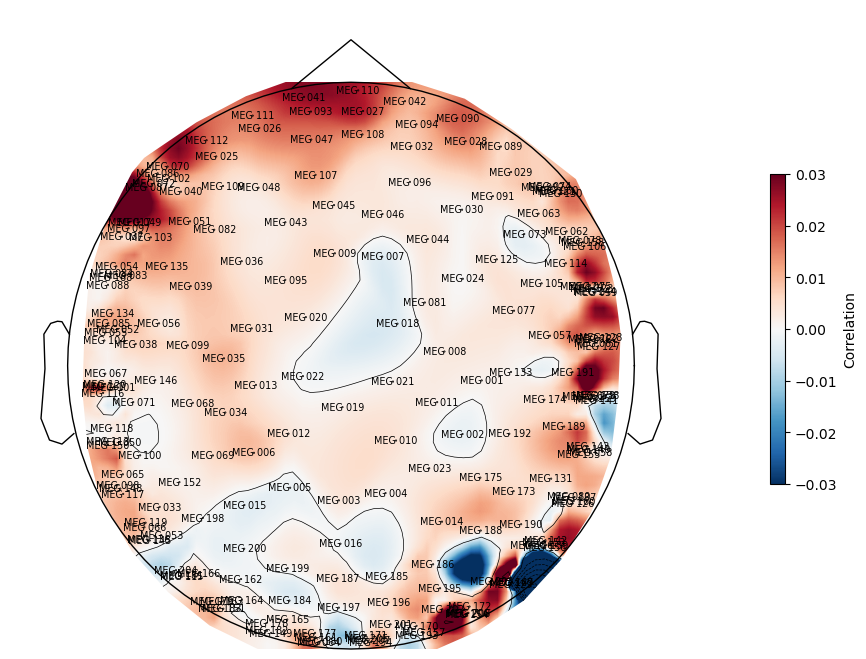

In [152]:
get_topomap(raw, mean_pc_complete_subj, (-0.024, 0.024))    # (-0.008, 0.024)

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


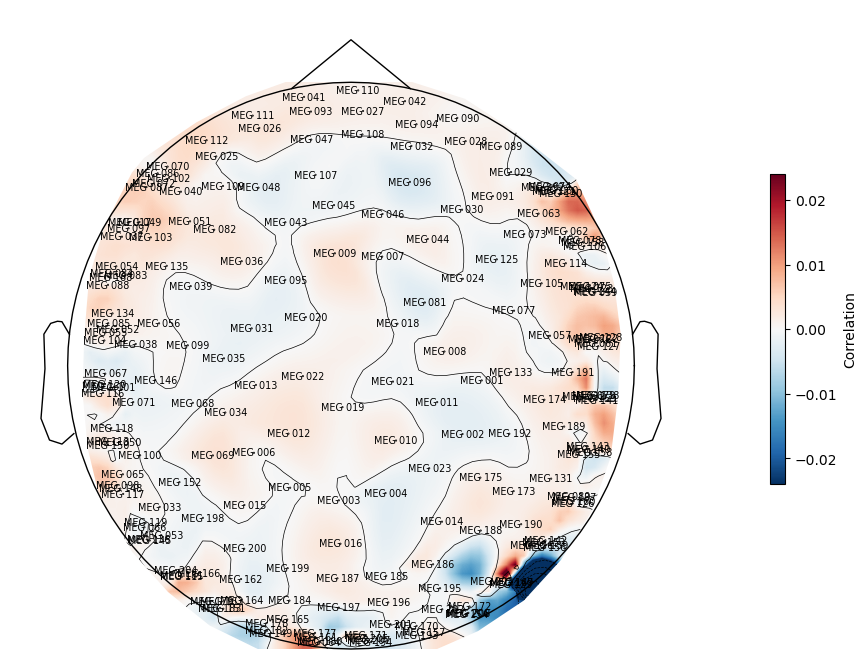

In [147]:
get_topomap(raw, mean_pc_delta_subj, (-0.024, 0.024))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


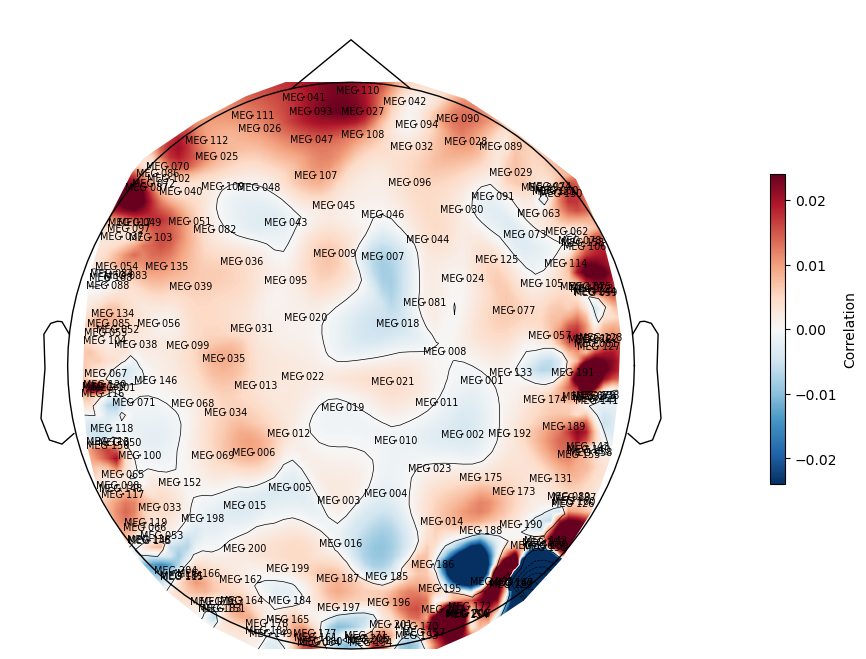

In [148]:
get_topomap(raw, mean_pc_theta_subj, (-0.024, 0.024))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


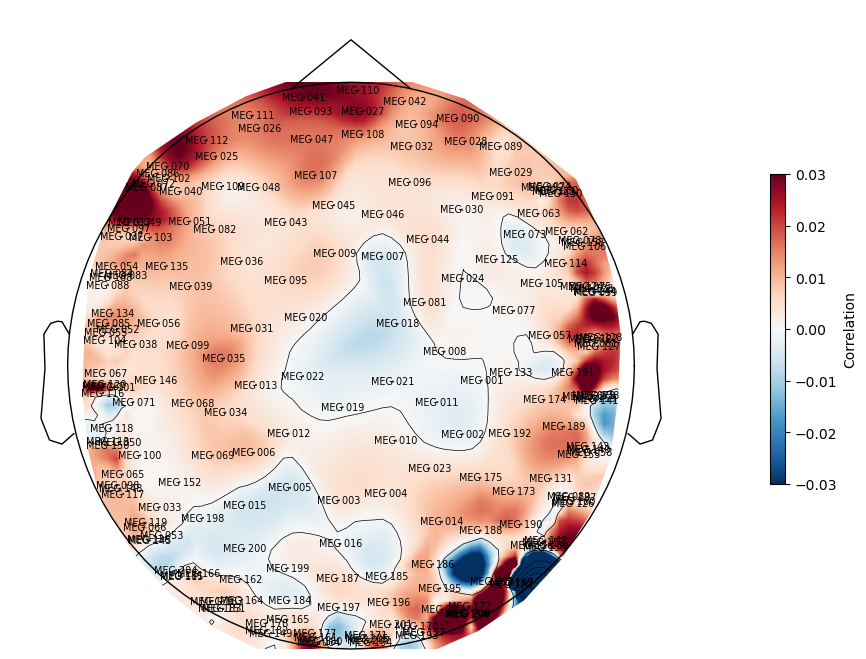

In [153]:
get_topomap(raw, mean_pc_alpha_subj, (-0.024, 0.024))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


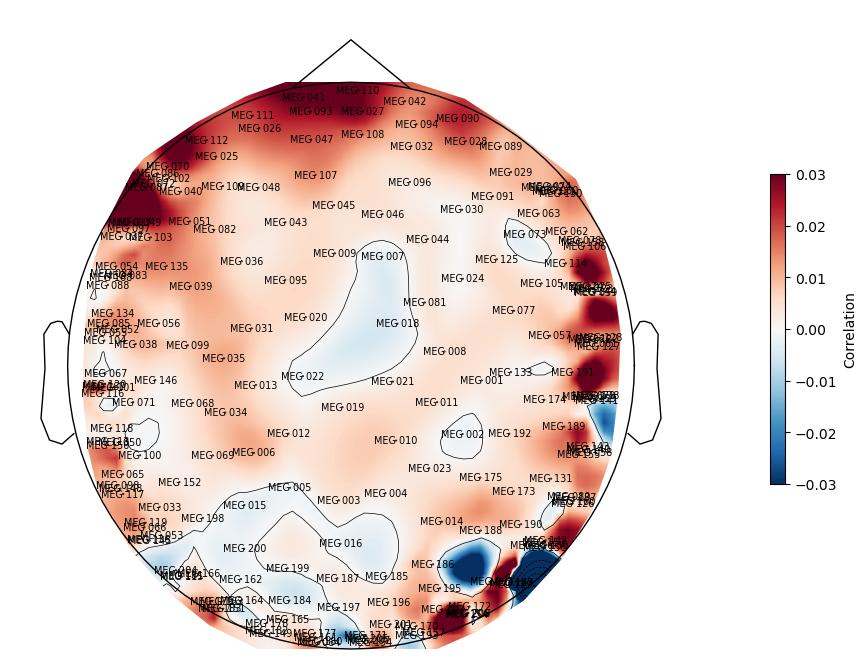

In [154]:
get_topomap(raw, mean_pc_beta_subj, (-0.024, 0.024))

## Ceiling (doesn't work)

In [5]:
import itertools
combinations = itertools.combinations(subjects_list, 2)

In [6]:
def get_ceiling(start_band, end_band):
    
    combinat_list = []
    for combo in tqdm(combinations):
        subj_i = combo[0]
        subj_j = combo[1]

        megsp_list_session_0_i = [f for f in megsp_list if f.startswith(subj_i) and f.split('_')[1] == '0']
        megsp_list_session_1_i = [f for f in megsp_list if f.startswith(subj_i) and f.split('_')[1] == '1']
        meg_0_tensor_train_i, _, _ = get_splitted_tensor(megsp_list_session_0_i, megsp_path)
        meg_1_tensor_train_i, _, _ = get_splitted_tensor(megsp_list_session_1_i, megsp_path)
        meg_tensor_train_i = torch.cat((meg_0_tensor_train_i, meg_1_tensor_train_i), 0)
        meg_tensor_train_i = meg_tensor_train_i[:, :, start_band:end_band, :]
        
        megsp_list_session_0_j = [f for f in megsp_list if f.startswith(subj_j) and f.split('_')[1] == '0']
        megsp_list_session_1_j = [f for f in megsp_list if f.startswith(subj_j) and f.split('_')[1] == '1']
        meg_0_tensor_train_j, _, _ = get_splitted_tensor(megsp_list_session_0_j, megsp_path)
        meg_1_tensor_train_j, _, _ = get_splitted_tensor(megsp_list_session_1_j, megsp_path)
        meg_tensor_train_j = torch.cat((meg_0_tensor_train_j, meg_1_tensor_train_j), 0)
        meg_tensor_train_j = meg_tensor_train_j[:, :, start_band:end_band, :]

        r2_channels = []
        for i in range(num_channel):
            pearson_corr = np.corrcoef(meg_tensor_train_i[:,i,:].reshape(-1), meg_tensor_train_j[:,i,:].reshape(-1))[0,1]
            modified_r2 = np.abs(pearson_corr) * pearson_corr
            r2_channels.append(modified_r2)

        combinat_list.append(r2_channels)
    
    return combinat_list


In [7]:
combination_beta = get_ceiling(7, 16)

28it [09:21, 20.07s/it]


In [8]:
for i in range(len(combination_beta)):
    combination_beta[i] = torch.Tensor(combination_beta[i])
comb_torch = torch.stack(combination_beta)
mean_vector = torch.mean(comb_torch, dim=0)



In [11]:
# CEILING VALUES OF DELTA

mean_vector

tensor([0.0413, 0.0452, 0.0372, 0.0508, 0.0398, 0.0444, 0.0559, 0.0447, 0.0517,
        0.0376, 0.0339, 0.0374, 0.0426, 0.0527, 0.0438, 0.0398, 0.0508, 0.0495,
        0.0419, 0.0524, 0.0415, 0.0397, 0.0513, 0.0450, 0.0551, 0.0557, 0.0486,
        0.0461, 0.0446, 0.0463, 0.0502, 0.0488, 0.0362, 0.0460, 0.0457, 0.0546,
        0.0575, 0.0414, 0.0536, 0.0497, 0.0581, 0.0698, 0.0549, 0.0427, 0.0534,
        0.0485, 0.0502, 0.0562, 0.0457, 0.0425, 0.0502, 0.0421, 0.0353, 0.0543,
        0.0489, 0.0425, 0.0433, 0.0413, 0.0473, 0.0582, 0.0499, 0.0464, 0.0460,
        0.0533, 0.0404, 0.0410, 0.0346, 0.0393, 0.0465, 0.0569, 0.0386, 0.0680,
        0.0573, 0.0520, 0.0479, 0.0413, 0.0426, 0.0541, 0.0311, 0.0369, 0.0594,
        0.0547, 0.0463, 0.0554, 0.0479, 0.0615, 0.0632, 0.0523, 0.0541, 0.0514,
        0.0542, 0.0563, 0.0528, 0.0601, 0.0458, 0.0571, 0.0604, 0.0422, 0.0404,
        0.0376, 0.0403, 0.0505, 0.0488, 0.0453, 0.0473, 0.0555, 0.0695, 0.0493,
        0.0509, 0.0523, 0.0572, 0.0550, 

In [9]:
# CEILING VALUES OF THETA

mean_vector

tensor([0.0004, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0004, 0.0003, 0.0004,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0004, 0.0003, 0.0003, 0.0008, 0.0003,
        0.0002, 0.0004, 0.0003, 0.0002, 0.0003, 0.0005, 0.0008, 0.0008, 0.0007,
        0.0009, 0.0014, 0.0007, 0.0004, 0.0006, 0.0004, 0.0002, 0.0003, 0.0006,
        0.0012, 0.0007, 0.0005, 0.0009, 0.0006, 0.0006, 0.0006, 0.0007, 0.0005,
        0.0005, 0.0007, 0.0007, 0.0011, 0.0006, 0.0008, 0.0009, 0.0005, 0.0007,
        0.0010, 0.0006, 0.0006, 0.0013, 0.0010, 0.0014, 0.0009, 0.0013, 0.0011,
        0.0005, 0.0006, 0.0006, 0.0115, 0.0003, 0.0003, 0.0007, 0.0007, 0.0014,
        0.0008, 0.0011, 0.0010, 0.0008, 0.0009, 0.0010, 0.0065, 0.0005, 0.0005,
        0.0005, 0.0009, 0.0009, 0.0008, 0.0010, 0.0027, 0.0013, 0.0010, 0.0010,
        0.0007, 0.0012, 0.0008, 0.0006, 0.0005, 0.0005, 0.0010, 0.0006, 0.0005,
        0.0006, 0.0008, 0.0061, 0.0009, 0.0014, 0.0008, 0.0011, 0.0004, 0.0006,
        0.0008, 0.0008, 0.0010, 0.0010, 

In [9]:
# CEILING VALUES OF ALPHA

mean_vector

tensor([3.5400e-04, 3.8109e-04, 3.4806e-04, 4.1767e-04, 4.7861e-04, 4.4342e-04,
        1.9671e-04, 1.9294e-04, 1.2458e-04, 4.3056e-04, 4.2461e-04, 3.7553e-04,
        2.7467e-04, 8.0964e-04, 5.2956e-04, 7.6261e-04, 2.1343e-04, 1.9762e-04,
        3.0271e-04, 2.4648e-04, 3.0100e-04, 2.1733e-04, 5.3699e-04, 2.3625e-04,
        3.7020e-04, 3.9959e-04, 4.4329e-04, 3.1413e-04, 6.0209e-04, 1.5981e-04,
        1.7789e-04, 2.3475e-04, 5.7972e-04, 2.9182e-04, 1.7391e-04, 1.9385e-04,
        7.8224e-04, 2.4050e-04, 2.1489e-04, 3.0110e-04, 4.3481e-04, 3.5928e-04,
        2.8380e-04, 2.5478e-04, 1.9828e-04, 2.0066e-04, 4.8933e-04, 3.9772e-04,
        5.1752e-04, 3.3242e-04, 2.7633e-04, 2.8546e-04, 5.1600e-04, 6.1766e-05,
        3.0087e-04, 2.0089e-04, 8.6408e-05, 6.7532e-04, 7.5861e-04, 1.2498e-03,
        6.2976e-04, 7.8933e-04, 3.9936e-04, 4.9388e-04, 3.3330e-04, 4.0060e-04,
        8.7449e-03, 3.2427e-04, 4.0385e-04, 1.1128e-04, 3.7304e-04, 1.2769e-03,
        1.8964e-04, 8.2328e-04, 6.1963e-

In [9]:
# CEILING VALUES OF BETA

mean_vector

tensor([0.0049, 0.0041, 0.0038, 0.0034, 0.0038, 0.0041, 0.0012, 0.0028, 0.0014,
        0.0035, 0.0045, 0.0029, 0.0022, 0.0055, 0.0051, 0.0062, 0.0023, 0.0020,
        0.0021, 0.0017, 0.0029, 0.0020, 0.0042, 0.0020, 0.0011, 0.0009, 0.0021,
        0.0020, 0.0030, 0.0016, 0.0015, 0.0013, 0.0098, 0.0030, 0.0021, 0.0011,
        0.0027, 0.0032, 0.0017, 0.0013, 0.0010, 0.0012, 0.0013, 0.0019, 0.0009,
        0.0012, 0.0015, 0.0014, 0.0046, 0.0065, 0.0014, 0.0036, 0.0126, 0.0017,
        0.0060, 0.0015, 0.0037, 0.0090, 0.0038, 0.0029, 0.0050, 0.0033, 0.0027,
        0.0056, 0.0086, 0.0138, 0.0364, 0.0035, 0.0043, 0.0008, 0.0044, 0.0022,
        0.0019, 0.0022, 0.0024, 0.0040, 0.0044, 0.0023, 0.0130, 0.0064, 0.0017,
        0.0010, 0.0020, 0.0030, 0.0045, 0.0012, 0.0079, 0.0032, 0.0019, 0.0021,
        0.0014, 0.0028, 0.0015, 0.0014, 0.0016, 0.0010, 0.0019, 0.0078, 0.0025,
        0.0069, 0.0060, 0.0042, 0.0013, 0.0065, 0.0032, 0.0031, 0.0011, 0.0014,
        0.0013, 0.0015, 0.0013, 0.0014, 

In [9]:
# CEILING VALUES OF 0-30  

mean_vector

tensor([0.0427, 0.0378, 0.0272, 0.0347, 0.0300, 0.0393, 0.0429, 0.0400, 0.0459,
        0.0284, 0.0320, 0.0275, 0.0334, 0.0487, 0.0416, 0.0341, 0.0662, 0.0392,
        0.0239, 0.0394, 0.0307, 0.0291, 0.0394, 0.0482, 0.0840, 0.0730, 0.0582,
        0.0666, 0.0755, 0.0535, 0.0420, 0.0540, 0.0609, 0.0427, 0.0424, 0.0585,
        0.0976, 0.0643, 0.0633, 0.0859, 0.0673, 0.0703, 0.0537, 0.0465, 0.0488,
        0.0432, 0.0582, 0.0608, 0.0717, 0.0704, 0.0735, 0.0747, 0.0669, 0.0782,
        0.0961, 0.0526, 0.0548, 0.0946, 0.0821, 0.0693, 0.0888, 0.0838, 0.0752,
        0.0708, 0.0726, 0.0810, 0.0817, 0.0455, 0.0458, 0.0760, 0.0638, 0.0764,
        0.0666, 0.0794, 0.0759, 0.0655, 0.0643, 0.0708, 0.0437, 0.0603, 0.0506,
        0.0628, 0.0791, 0.0954, 0.0915, 0.0728, 0.0741, 0.0998, 0.0807, 0.0729,
        0.0646, 0.0864, 0.0663, 0.0621, 0.0451, 0.0527, 0.0820, 0.0697, 0.0492,
        0.0632, 0.0739, 0.0872, 0.0785, 0.1099, 0.0621, 0.0787, 0.0601, 0.0544,
        0.0679, 0.0654, 0.0775, 0.0921, 

## Null distribution

In [ ]:
extr_path = meg_path + "/collect_data"
subjects_metrics_null = {}

list_subj_null = []
for repo in tqdm(os.listdir(extr_path)[3:-2]):
    subject = repo[-2:]
    print(subject)
    subj_path = extr_path + '/' + repo + '/'
    megsp_list_session_0 = [f for f in megsp_list if f.startswith(subject) and f.split('_')[1] == '0']
    megsp_list_session_1 = [f for f in megsp_list if f.startswith(subject) and f.split('_')[1] == '1']
    meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
    meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
    meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)

    distr_list = []
    null_distr_iter = 30
    for i in tqdm(range(null_distr_iter)):
        pred_meg_y = torch.load(os.path.join(subj_path, 'meg_prediction_ridge_'+subject+'.pt')) 
        pred_meg_y = pred_meg_y.permute(1, 0, 2)
        pred_meg_y = pred_meg_y.reshape(pred_meg_y.shape[0], pred_meg_y.shape[1], 16, 26)
        # flattened_tensor = pred_meg_y
        flattened_tensor = pred_meg_y.reshape(pred_meg_y.shape[0], pred_meg_y.shape[1], -1)
        num_elements = flattened_tensor.shape[-1]
        print(num_elements)
        random_indices = np.random.permutation(num_elements)
        shuffled_tensor = flattened_tensor[:, :, random_indices]
        shuffled_tensor = shuffled_tensor.reshape(pred_meg_y.shape)
        print(shuffled_tensor.shape)
        print(meg_tensor_test.shape)
        # subjects_metrics_null['subject_'+subject] = bands_metrics(meg_tensor_test, shuffled_tensor, freq_bands)
        get_metrics = bands_metrics(meg_tensor_test, shuffled_tensor, freq_bands)
        distr_list.append(get_metrics)

    mod_r2_null = np.empty((208,null_distr_iter))
    for i in range(null_distr_iter):
        temp_list = distr_list[i]['complete']
        for j, h in enumerate(temp_list):
            mod_r2_null[j,i] = h['modified_r2']
    
    list_subj_null.append(mod_r2_null)


       


            

In [185]:
list_subj_null = np.load('/data01/data/MEG/collect_data/results/null_distr/null_distr_ridge_text_clip_.npy')
# list_subj_null = list_subj_null[0:-1]

In [186]:
list_subj_null.shape

(8, 208, 30)

In [187]:
mean_tensor = np.mean(list_subj_null, 0)

In [65]:
# tensors_subj_null = [torch.tensor(array) for array in list_subj_null]
# stacked_subj_null = torch.stack(tensors_subj_null)
# mean_tensor = torch.mean(stacked_subj_null, dim=0)

In [188]:
mean_tensor.shape

(208, 30)

In [189]:
mean_r2_complete_subj.shape

torch.Size([208])

In [190]:
from scipy.stats import ttest_ind, ttest_1samp

z = []
p_v = []
for index in range(208):

    media = mean_tensor[index,:].mean()
    devstd = mean_tensor[index,:].std()

    t_st, p = ttest_1samp(mean_tensor[index,:], mean_r2_complete_subj[index])
    t = float((mean_r2_complete_subj[index] - media)/devstd)
    z.append(t)
    p_v.append(p)



In [191]:
print(np.min(z))
print(np.max(z))
print('-----------------')
print(np.mean(z))    # la media vera è x-volte più grande in media della media fake (null distribution)
print(np.std(z))

-4.782891273498535
25.3662109375
-----------------
7.892955515139665
5.777195453017361


In [192]:
print(np.min(p_v))
print(np.max(p_v))
print('-----------------')
print(np.mean(p_v))    
print(np.std(p_v))

2.7171966305320945e-42
0.9244112947780481
-----------------
0.004833397773649279
0.06408540350625785


media 0.0001359715091616699
std 0.00025146500329237823


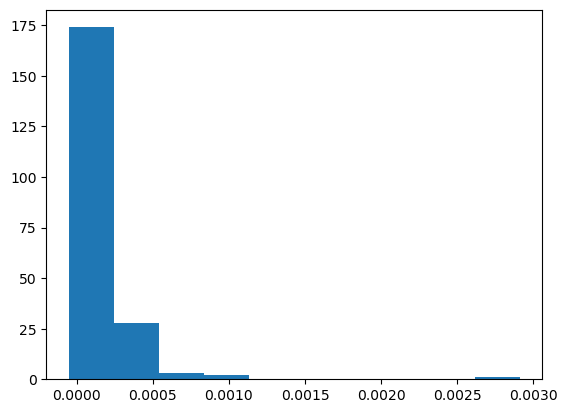

In [193]:
distr_rand = 29
plt.hist([mean_tensor[:,distr_rand]])
print('media', mean_tensor[:,distr_rand].mean())
print('std', mean_tensor[:,distr_rand].std())

In [174]:
import seaborn as sns

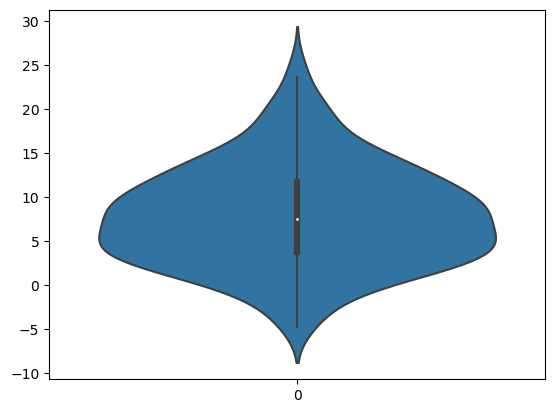

In [194]:
sns.violinplot(z) 
plt.show()